In [1]:
#dataset = whole set 
#df = set of selected assets only
#return = log(c_{i,t}/c_{i,t+1}
#reward = (4/3)*(1+((np.pi)*(np.arctan(np.log(df.loc[:,'H'+str(t)])))))**2-(4/3)
#T[i]= number of times asset i is selected for set S (started it from 20)
#mu= algoritm confidence level belongs to (0,1)

In [2]:
#functions :
#  get_cost(t)  
#estimated_reward
#estimated_reward_plus
#estimated_reward_minus
#get_cost_for_k
#get_start_point() it gives x_{i,1}'s for all i's
#negative_cvar
#et_weight_from_securities() #get weights of each asset from x_{i,t}'s

In [3]:
#importing libraries
import numpy as np
import pandas as pd
import string
import random

In [4]:
#function to generate a random name of stock
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [5]:
#function to generate random cost at 1st trial of stock
def cost_generator(cost_low, cost_up):
    return random.uniform(cost_low,cost_up)


In [6]:
#importing data 
dataset=pd.read_csv(r'C:\Users\Sneha\Desktop\dataa.csv')
#dataset

In [7]:
#theta
theta=5
#Cost Bound
Cost_Bound=100
#number of assets
no_of_assets=100
#algorithm satisfy constraints with probability atleast (1-mu) 
mu= 0.1
#number of R_{i,t} trials
no_of_trials=2000

#appending rows to dataset
p=dataset
for j in range(0,no_of_assets):
    p=p.append({'Name':id_generator(),'Cost_1':cost_generator(5,15),'H1':cost_generator(0,1)},ignore_index=True)

dataset=p

In [8]:
dataset.index += 1

In [9]:
#creating columns
column=[]
for j in range(0,2019):
    x= np.random.uniform(low=0, high=2*dataset.loc[:,'H1'], size=no_of_assets)
    column.append(x)


In [10]:
#naming the headers for historical data rewards
h=[]
for j in range(2,21):
    h.append('H'+str(j))

#naming the headers for current data rewards
r=[]
for j in range(1,no_of_trials+1):
    r.append('R'+str(j))
#appending columns 
for j in range (0,19):
    dataset[h[j]]=column[j]
for j in range(19,no_of_trials+19):
    dataset[r[j-19]]=column[j]


#dataset
# here columns of dataset represent (c_{i,t+1}/c_{i,t}) 
#considering trial 1 at Cost_1
# H1 implies c_{i,2}/c_{i,1}
#cost at trial 2 is H1*Cost_1
#at trial 2 H2 is unknown 
#reward at trial 2 is determined using H2 
#if H20 is considered to be the start
#then cost at trial 1 is multiplication of columns till H20(all historical returns)
#trial 1 begins from R1, where cost will be calculated by multiplying dataset entries till 20
# And trial 1 estimated reward vector will be mean of reward till H20

In [11]:
def get_cost(t):
    if (t==1):
        y=np.multiply(dataset.loc[:,"Cost_1"],dataset.loc[:,"H1"])
        i=2
        while (i<=20):
            y=np.multiply(y,dataset.loc[:,"H"+str(i)])
            i=i+1
    else:
        y=np.multiply(dataset.loc[:,"Cost_1"],dataset.loc[:,"H1"])
        i=2
        while (i<=20):
            y=np.multiply(y,dataset.loc[:,"H"+str(i)])
            i=i+1
        j=1
        while (j<=(t-1)):
            y=np.multiply(y,dataset.loc[:,"R"+str(j)])
            j=j+1   
            
    return list(y)
#get_cost(2) will return cost of assets at trial 2 by multiplying till R1

In [12]:
#Testing of cost vector 
#y=np.multiply(dataset.loc[:,"Cost_1"],dataset.loc[:,"H1"])
#i=2
#while (i<=20):
#    y=np.multiply(y,dataset.loc[:,"H"+str(i)])
#    i=i+1
#y
#np.multiply(y, dataset.loc[:,"R1"])

In [13]:
#testing np.multiply
#a=[1,2]
#b=[2,3]
#c=[3,4]
#np.multiply(a,b)

In [14]:
#construction of complete graph and then min spanning tree to choose a set of assets and used prims algo to construct min spanning tree


from math import log

#historical return vectors (return implies log(c_{i,t}/c_{i,t+1}))
historical_returns=[]
for i in range(0,no_of_assets):
    ro=dataset.iloc[i]
    
    row=ro[2:22]#here in 1:5 1 is included and 5 is not included 
    k=[log(y) for y in row]
    historical_returns.append(k)

#historical_returns[0]

#-----------------------------------------
delta=[]
edge_length=[]
for i in range(0,no_of_assets):
    delta.append([])
    for j in range(0,no_of_assets):
        p=[]#h_{i,t}*h_{j,t}
        for t in range(0,20):
            p.append(historical_returns[i][t]*historical_returns[j][t])
        q=[]#h_{i,t}
        for t in range(0,20):
            q.append(historical_returns[i][t])
        o=[]#h_{j,t}
        for t in range(0,20):
            o.append(historical_returns[j][t])
        s=[]#h_{i,t}^2
        for t in range(0,20):
            s.append(historical_returns[i][t]*historical_returns[i][t])
        m=[]#h_{j,t}^2
        for t in range(0,20):
            m.append(historical_returns[j][t]*historical_returns[j][t])

        delta[i].append(((no_of_assets*sum(p))-(sum(q)*sum(o)))/np.sqrt(((no_of_assets*sum(s))-(sum(q)*sum(q)))*((no_of_assets*sum(m))-(sum(o)*sum(o)))))
        
for i in range(0,no_of_assets):
    edge_length.append([])
    for j in range(0,no_of_assets):
        y=np.sqrt(2*(1-delta[i][j]))
        edge_length[i].append(y)
#edge_length

#--------------------------------------------
#prim's algo to calculate adjecency matrix for minimum spanning tree
import sys # Library for INT_MAX 
from itertools import chain
from operator import sub
imap=map
  
class Graph(): 
  
    def __init__(self, vertices): 
        self.V = vertices 
        self.graph = [[0 for column in range(vertices)]  
                    for row in range(vertices)] 
  
    # A utility function to print the constructed MST stored in parent[] 
    def printMST(self, parent): 
        print("Edge \tWeight")
        for i in range(1,self.V):
            print(parent[i],"-",i,"\t",self.graph[i][ parent[i] ])
            

    
    def missing_numbers(self,parent):
        parent.sort()
        original_list = [x for x in range(parent[0], no_of_assets + 1)]
        parent = set(parent)
        return (list(parent ^ set(original_list)))
    
  
    # A utility function to find the vertex with  
    # minimum distance value, from the set of vertices  
    # not yet included in shortest path tree 
    def minKey(self, key, mstSet): 
  
        # Initilaize min value 
        min = sys.maxsize 
  
        for v in range(self.V): 
            if key[v] < min and mstSet[v] == False: 
                min = key[v] 
                min_index = v 
  
        return min_index 
  
    # Function to construct and print MST for a graph  
    # represented using adjacency matrix representation 
    def primMST(self): 
  
        #Key values used to pick minimum weight edge in cut 
        key = [sys.maxsize] * self.V 
        parent = [None] * self.V # Array to store constructed MST 
        # Make key 0 so that this vertex is picked as first vertex 
        key[0] = 0 
        mstSet = [False] * self.V 
  
        parent[0] = -1 # First node is always the root of 
  
        for cout in range(self.V): 
  
            # Pick the minimum distance vertex from  
            # the set of vertices not yet processed.  
            # u is always equal to src in first iteration 
            u = self.minKey(key, mstSet) 
  
            # Put the minimum distance vertex in  
            # the shortest path tree 
            mstSet[u] = True
  
            # Update dist value of the adjacent vertices  
            # of the picked vertex only if the current  
            # distance is greater than new distance and 
            # the vertex in not in the shotest path tree 
            for v in range(self.V): 
                # graph[u][v] is non zero only for adjacent vertices of m 
                # mstSet[v] is false for vertices not yet included in MST 
                # Update the key only if graph[u][v] is smaller than key[v] 
                if self.graph[u][v] > 0 and mstSet[v] == False and key[v] > self.graph[u][v]: 
                        key[v] = self.graph[u][v] 
                        parent[v] = u 
  
        self.printMST(parent)
        new_list = [x+1 for x in parent]
        print(new_list)
        return(self.missing_numbers(new_list))
        

g = Graph(no_of_assets) 
n = no_of_assets
matrix = np.zeros((n,no_of_assets)) # Pre-allocate matrix
for i in range(0,n):
    matrix[i,:] = edge_length[i]
g.graph = matrix
  
k=g.primMST(); 
#k

Edge 	Weight
6 - 1 	 0.7098567805693193
4 - 2 	 0.41336633138762985
90 - 3 	 0.44355946652013445
18 - 4 	 0.2644541849977907
9 - 5 	 0.432812943287486
85 - 6 	 0.48923503699219173
18 - 7 	 0.21533545498345877
99 - 8 	 0.894354607514534
18 - 9 	 0.2602714078238845
56 - 10 	 0.772311655429493
69 - 11 	 0.6534870476262067
70 - 12 	 1.0982324190591501
38 - 13 	 0.556383132527678
43 - 14 	 0.7781394715054556
32 - 15 	 0.4285844490986843
9 - 16 	 0.48880131202853266
0 - 17 	 0.37709014780444555
17 - 18 	 0.30820153843939857
85 - 19 	 0.69892884668353
31 - 20 	 0.8450535576610966
16 - 21 	 0.8292376169978634
18 - 22 	 0.23357432309145823
9 - 23 	 0.28001636968279825
89 - 24 	 0.517549487627788
50 - 25 	 0.5225392918697314
16 - 26 	 0.5525219708660203
35 - 27 	 0.6468320624144827
82 - 28 	 0.5514418549672532
22 - 29 	 0.42962270198073615
18 - 30 	 0.23623301888075654
88 - 31 	 0.48488027935653566
30 - 32 	 0.4168852908907883
22 - 33 	 0.45307002728124707
32 - 34 	 0.43695842061819135
38 - 35 	

In [15]:
df=dataset.loc[k,:]
df

,Name,Cost_1,H1,H2,H3,H4,H5,H6,H7,H8,...,R1991,R1992,R1993,R1994,R1995,R1996,R1997,R1998,R1999,R2000
2,PV2IPX,5.038117,0.835735,1.589758,1.487095,0.983900,0.248905,0.038034,1.520773,0.565814,...,0.374233,0.079713,0.331840,0.445684,1.014169,0.446604,1.307291,0.501331,1.395232,0.567960
9,T7DTIG,6.170093,0.861015,1.491885,0.388704,0.303404,0.291861,1.185245,1.110719,0.401375,...,1.363263,0.005645,0.707717,1.441140,0.230907,1.123617,0.363932,1.323259,1.092587,1.146443
11,HTEDMB,5.337605,0.601614,0.717822,1.158810,0.699972,0.406064,0.765946,0.846085,0.735594,...,0.466795,0.266191,0.717479,0.150243,1.041188,0.882118,1.036286,0.145335,0.402870,0.185906
12,CEPLFO,10.284382,0.671644,1.084973,1.168672,0.724060,0.310944,0.257220,1.009307,1.291811,...,0.542760,1.312476,0.264253,1.048437,1.063177,0.150586,0.940793,0.710916,0.823709,0.440530
13,CNBYS3,9.356291,0.937390,0.300731,1.632274,0.908328,1.715092,1.622313,1.394172,1.437609,...,1.632324,0.159648,0.915547,0.612437,1.412655,1.162172,0.812511,1.351329,0.532182,0.756806
14,2XZT21,13.258820,0.326078,0.164465,0.513230,0.422354,0.345787,0.530717,0.006348,0.035507,...,0.496231,0.090437,0.623189,0.599199,0.246096,0.592078,0.512876,0.089486,0.282901,0.463123
15,DNN3DP,10.093455,0.876985,0.088443,0.383761,0.305644,0.355502,1.045151,0.413347,0.469768,...,0.371582,0.134904,0.560739,1.476387,0.303390,0.390836,0.348461,1.670531,0.517499,1.505587
20,0V3A2X,14.814455,0.610612,0.191412,0.010825,0.089612,0.223186,0.046246,0.350807,0.338857,...,0.427678,0.458192,0.109410,0.658182,0.767887,0.256473,1.043085,0.068918,0.523834,0.979901
21,1NIXN8,13.551261,0.968877,0.216392,0.504142,0.289065,0.575558,1.225706,1.832520,0.696728,...,0.210890,0.744018,0.974609,0.960943,1.780807,1.288110,0.717676,1.378187,1.637874,0.619832
22,QW3USH,11.800536,0.831968,1.287700,0.728342,0.335391,1.435803,0.851525,0.201946,0.342744,...,1.148539,1.456334,0.464729,1.087713,0.007711,0.364899,0.705076,1.505881,0.625855,0.510318


In [16]:
#reward of trial t will be revealed at trial t+1
#generate reward
historical_reward=[]
present_reward=[]

for t in range(1,21):
   # historical_reward.append([])
    #m=[]
    #for i in range(0,len(k)):
    historical_reward.append((4/3)*(1+((1/(np.pi))*(np.arctan(np.log(df.loc[:,'H'+str(t)])))))**2-(4/3))
for t in range(1,no_of_trials+1):
    present_reward.append((4/3)*(1+((1/(np.pi))*(np.arctan(np.log(df.loc[:,'R'+str(t)])))))**2-(4/3))

In [17]:
#historical_reward[1]
#print(k)
#present_reward
#historical_reward

In [18]:
len(k)

47

In [19]:
column_reward=[]
for i in range(0,20):
    column_reward.append(historical_reward[i])
for i in range(0,no_of_trials):
    column_reward.append(present_reward[i])

dataset_reward = pd.DataFrame({})

dataset_reward['H1']=column_reward[0]
for j in range (0,19):
    dataset_reward[h[j]]=column_reward[j+1]
    
for j in range(19,no_of_trials+19):
    dataset_reward[r[j-19]]=column_reward[j+1]
    
dataset_reward


,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,...,R1991,R1992,R1993,R1994,R1995,R1996,R1997,R1998,R1999,R2000
2,-0.146454,0.393924,0.339937,-0.013740,-0.682913,-0.862113,0.358242,-0.403218,0.343756,0.032275,...,-0.577826,-0.821057,-0.614194,-0.514526,0.011969,-0.513696,0.231489,-0.463622,0.286866,-0.401187
9,-0.123105,0.342577,-0.565207,-0.638097,-0.647693,0.146720,0.090287,-0.554072,-0.629386,0.103788,...,0.267269,-0.914097,-0.267564,0.313976,-0.697473,0.100308,-0.586745,0.241890,0.076020,0.117782
11,-0.369206,-0.257890,0.127110,-0.274984,-0.549932,-0.212014,-0.136864,-0.240905,-0.226033,-0.778029,...,-0.495367,-0.668827,-0.258218,-0.762129,0.034462,-0.103812,0.030413,-0.766085,-0.552753,-0.733558
12,-0.302154,0.069967,0.134479,-0.251923,-0.631796,-0.676151,0.007875,0.221255,-0.342874,-0.312439,...,-0.424961,0.234883,-0.670412,0.040422,0.052441,-0.761853,-0.051239,-0.264500,-0.157644,-0.519173
13,-0.054242,-0.640325,0.414762,-0.080123,0.452996,0.409956,0.286226,0.311934,0.290435,-0.535879,...,0.414786,-0.754571,-0.073655,-0.358876,0.297296,0.129629,-0.168108,0.259798,-0.434886,-0.220696
14,-0.619068,-0.750709,-0.452578,-0.535464,-0.602328,-0.436257,-0.912040,-0.865021,-0.825729,-0.672619,...,-0.468339,-0.811633,-0.348598,-0.371508,-0.685192,-0.378291,-0.452907,-0.812458,-0.655101,-0.498714
15,-0.108487,-0.813365,-0.569529,-0.636228,-0.594005,0.037724,-0.543479,-0.492653,-0.171989,0.155846,...,-0.580126,-0.774531,-0.408017,0.333990,-0.638109,-0.563338,-0.600042,0.432799,-0.448603,0.350062
20,-0.360619,-0.729156,-0.901321,-0.812348,-0.703690,-0.853144,-0.598033,-0.608235,-0.127305,-0.060557,...,-0.530709,-0.503198,-0.795508,-0.315068,-0.210174,-0.676759,0.036025,-0.830868,-0.442693,-0.017176
21,-0.026694,-0.709150,-0.461017,-0.650008,-0.393988,0.175869,0.502333,-0.278094,0.345569,-0.441543,...,-0.713565,-0.232869,-0.021737,-0.033586,0.481271,0.218786,-0.258029,0.276492,0.417444,-0.351808
22,-0.149954,0.218512,-0.247831,-0.611182,0.310886,-0.131841,-0.720729,-0.604925,0.121482,0.357922,...,0.119370,0.322688,-0.497251,0.072150,-0.908411,-0.585910,-0.270094,0.350221,-0.346046,-0.455285


In [20]:
#historical reward vector has different indexes 
#hence to take average columnwise, we have to construsct another variable 'p'
p=[]
for i in range(0,20):
    p.append(historical_reward[i][k[1]])
#p
#sum(p)/len(p)

In [21]:
#get estimated reward vector at trial t
def estimated_reward(t):#get_mean()
    asset, trial = no_of_assets, no_of_trials;
    r_hat = [] #\hat{r_{i,t}}
    for i in range(0,len(k)):
        if(t==1):
            p=[]
            for j in range(0,20):
                p.append(historical_reward[j][k[i]])
            r_hat.append(sum(p)/len(p))
            #r_hat.append(df.loc[i,"H1":"H20"].mean()) 
        else:
            q=[]
            for j in range(0,20):
                q.append(historical_reward[j][k[i]])
            for j in range(0,t-1):#trial 2 par R1 tak ka mean chahiye which is present_reward[0]
                q.append(present_reward[j][k[i]])
            r_hat.append(sum(q)/len(q))
            #r_hat.append(df.loc[i,"H1":"R"+str(t-1)].mean())
    return r_hat
#print(estimated_reward(1))
print(estimated_reward(1))

[-0.2165236549686489, -0.13720847699043737, -0.3297393723556752, -0.40115968367619254, 0.11337780386991267, -0.6388000487800473, -0.22032143896338724, -0.42121522589874827, -0.1489095640204575, -0.23371561694131024, -0.3284785406666406, -0.7569265258286515, -0.16102142684669724, -0.3501467880758594, -0.17654408986737363, -0.2365863003248431, 0.03775950603888005, -0.8109740053766317, -0.046677147168457375, -0.25763574359291946, -0.23138909481347167, -0.25783563041297675, -0.5344741669707368, -0.47833113575834363, -0.1262319206667482, -0.628302377436083, -0.7053924711951964, -0.33787649473324144, -0.699852449507563, -0.06719861691012866, -0.4038000729169034, -0.48008477833308894, -0.5631477083493149, -0.042231461329834165, -0.6904497946686586, -0.695606585789918, -0.22752429807667926, -0.33128765903340274, -0.2286251893752734, -0.18713709971073222, -0.14472449713442975, -0.03319407020643358, -0.1959719751910208, -0.39859718415504364, -0.5240891226229114, -0.5696862455980554, -0.133878196

In [22]:
import operator

def estimated_reward_plus(t):
    #n=number_of_assets in formula
    #vector=np.array([20] * df.shape[0])
        
    T=[None]*(no_of_assets+1)
    for i in range(0,len(k)):
        T[k[i]]=20
    for j in range(0,t):
        for i in range(0,len(k)):
            T[k[i]]=T[k[i]]+1

    error=[(1/(2*T[i]))*np.log((2*no_of_assets)/(mu)) for i in (k)]
    ret=map(sum, zip(estimated_reward(t),error))   
    return list(ret)
    
def reward_plus(t):
    #n=number_of_assets in formula
    #vector=np.array([20] * df.shape[0])
        
    T=[None]*(no_of_assets+1)
    for i in range(0,len(k)):
        T[k[i]]=20
    for j in range(0,t):
        for i in range(0,len(k)):
            T[k[i]]=T[k[i]]+1

    error=[(1/(2*T[i]))*np.log((2*no_of_assets)/(mu)) for i in (k)]
    #ret=map(sum, zip(estimated_reward(t),error))   
    return list(error)
    
def estimated_reward_minus(t):
    T=[None]*(no_of_assets+1)
    for i in range(0,len(k)):
        T[k[i]]=20
    for j in range(0,t):
        for i in range(0,len(k)):
            T[k[i]]=T[k[i]]+1

    error=[(1/(2*T[i]))*np.log((2*no_of_assets)/(mu)) for i in (k)]
    ret=map(operator.sub, estimated_reward(t),error)
        
    return list(ret)
def reward_minus(t):
    T=[None]*(no_of_assets+1)
    for i in range(0,len(k)):
        T[k[i]]=20
    for j in range(0,t):
        for i in range(0,len(k)):
            T[k[i]]=T[k[i]]+1

    error=[-((1/(2*T[i]))*np.log((2*no_of_assets)/(mu))) for i in (k)]
    
        
    return list(error)
    
print(estimated_reward_plus(1))


[-0.03554978688431362, 0.043765391093897904, -0.14876550427133992, -0.22018581559185726, 0.29435167195424794, -0.457826180695712, -0.03934757087905197, -0.240241357814413, 0.03206430406387778, -0.05274174885697497, -0.14750467258230535, -0.5759526577443163, 0.019952441237638036, -0.16917291999152415, 0.004429778216961638, -0.055612432240507825, 0.2187333741232153, -0.6300001372922964, 0.1342967209158779, -0.07666187550858419, -0.0504152267291364, -0.07686176232864148, -0.35350029888640155, -0.2973572676740084, 0.05474194741758706, -0.4473285093517477, -0.5244186031108612, -0.15690262664890617, -0.5188785814232277, 0.11377525117420662, -0.22282620483256813, -0.2991109102487537, -0.3821738402649797, 0.1387424067545011, -0.5094759265843234, -0.5146327177055827, -0.04655042999234399, -0.15031379094906747, -0.04765132129093813, -0.006163231626396953, 0.03624937094990552, 0.1477797978779017, -0.014998107106685532, -0.21762331607070837, -0.34311525453857616, -0.3887123775137201, 0.04709567128

In [23]:
print(estimated_reward_minus(1))

[-0.39749752305298414, -0.3181823450747726, -0.5107132404400104, -0.5821335517605278, -0.0675960642144226, -0.8197739168643825, -0.40129530704772254, -0.6021890939830835, -0.32988343210479276, -0.4146894850256455, -0.5094524087509759, -0.9379003939129867, -0.34199529493103253, -0.5311206561601947, -0.35751795795170893, -0.41756016840917837, -0.14321436204545523, -0.9919478734609669, -0.22765101525279263, -0.43860961167725476, -0.41236296289780694, -0.438809498497312, -0.715448035055072, -0.6593050038426789, -0.3072057887510835, -0.8092762455204182, -0.8863663392795317, -0.5188503628175767, -0.8808263175918982, -0.24817248499446393, -0.5847739410012387, -0.6610586464174242, -0.7441215764336502, -0.22320532941416943, -0.8714236627529939, -0.8765804538742532, -0.40849816616101453, -0.512261527117738, -0.4095990574596087, -0.36811096779506747, -0.32569836521876505, -0.21416793829076886, -0.3769458432753561, -0.5795710522393789, -0.7050629907072467, -0.7506601136823906, -0.314852064881406]


In [24]:
#appending element to a list
#n=get_cost(1)
#n.append(1)
#n

In [25]:
#print(get_cost(1))
#print(k)
#test code to construct (get_cost_for_k(t))
#m=[get_cost(1)[x] for x in k]# here if k[0]=2, then it will give get_cost(1)[2], i.e. 3rd entry, hence not correct
#m=[get_cost(2)[x-1] for x in k]
#m

#get_cost_for_k
def get_cost_for_k(t):
    m=[get_cost(t)[x-1] for x in k]
    return m
#get_cost_for_k(1)


In [26]:
import numpy as np
import pandas as pd

class BaseOptimizer:
    def __init__(self, n_assets, tickers=None):
        """
        :param n_assets: number of assets
        :type n_assets: int
        :param tickers: name of assets
        :type tickers: list
        """
        self.n_assets = n_assets
        if tickers is None:
            self.tickers = list(range(n_assets))
        else:
            self.tickers = tickers
        # Outputs
        self.weights = None

    def set_weights(self, weights):
        if self.weights is None:
            self.weights = [0] * self.n_assets
        for i, k in enumerate(self.tickers):
            if k in weights:
                self.weights[i] = weights[k]

    def clean_weights(self, cutoff=1e-4, rounding=5):
        """
        Helper method to clean the raw weights, setting any weights whose absolute
        values are below the cutoff to zero, and rounding the rest.
        :param cutoff: the lower bound, defaults to 1e-4
        :type cutoff: float, optional
        :param rounding: number of decimal places to round the weights, defaults to 5.
                         Set to None if rounding is not desired.
        :type rounding: int, optional
        :return: asset weights
        :rtype: dict
        """
        if not isinstance(rounding, int) or rounding < 1:
            raise ValueError("rounding must be a positive integer")
        clean_weights = self.weights.copy()
        clean_weights[np.abs(clean_weights) < cutoff] = 0
        if rounding is not None:
            clean_weights = np.round(clean_weights, rounding)
        return dict(zip(self.tickers, clean_weights))


class BaseScipyOptimizer(BaseOptimizer):
    def __init__(self, n_assets, tickers=None, weight_bounds=(0, 1)):
        """
        :param weight_bounds: minimum and maximum weight of an asset, defaults to (0, 1).
                              Must be changed to (-1, 1) for portfolios with shorting.
        :type weight_bounds: tuple, optional
        """
        super().__init__(n_assets, tickers)
        self.bounds = self._make_valid_bounds(weight_bounds)
        # Optimisation parameters
        self.initial_guess = np.array([1 / self.n_assets] * self.n_assets)
        self.constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]

    def _make_valid_bounds(self, test_bounds):
        """
        Private method: process input bounds into a form acceptable by scipy.optimize,
        and check the validity of said bounds.
        :param test_bounds: minimum and maximum weight of an asset
        :type test_bounds: tuple
        :raises ValueError: if ``test_bounds`` is not a tuple of length two.
        :raises ValueError: if the lower bound is too high
        :return: a tuple of bounds, e.g ((0, 1), (0, 1), (0, 1) ...)
        :rtype: tuple of tuples
        """
        if len(test_bounds) != 2 or not isinstance(test_bounds, tuple):
            raise ValueError(
                "test_bounds must be a tuple of (lower bound, upper bound)"
            )
        if test_bounds[0] is not None:
            if test_bounds[0] * self.n_assets > 1:
                raise ValueError("Lower bound is too high")
        return (test_bounds,) * self.n_assets


def portfolio_performance(
    expected_returns, cov_matrix, weights, verbose=False, risk_free_rate=0.02
):
    """
    After optimising, calculate (and optionally print) the performance of the optimal
    portfolio. Currently calculates expected return, volatility, and the Sharpe ratio.
    :param expected_returns: expected returns for each asset. Set to None if
                             optimising for volatility only.
    :type expected_returns: pd.Series, list, np.ndarray
    :param cov_matrix: covariance of returns for each asset
    :type cov_matrix: pd.DataFrame or np.array
    :param weights: weights or assets
    :type weights: list, np.array or dict, optional
    :param verbose: whether performance should be printed, defaults to False
    :type verbose: bool, optional
    :param risk_free_rate: risk-free rate of borrowing/lending, defaults to 0.02
    :type risk_free_rate: float, optional
    :raises ValueError: if weights have not been calcualted yet
    :return: expected return, volatility, Sharpe ratio.
    :rtype: (float, float, float)
    """
    if isinstance(weights, dict):
        if isinstance(expected_returns, pd.Series):
            tickers = list(expected_returns.index)
        elif isinstance(cov_matrix, pd.DataFrame):
            tickers = list(cov_matrix.columns)
        else:
            tickers = list(range(len(expected_returns)))
        newweights = np.zeros(len(tickers))
        for i, k in enumerate(tickers):
            if k in weights:
                newweights[i] = weights[k]
        if newweights.sum() == 0:
            raise ValueError("Weights add to zero, or ticker names don't match")
    elif weights is not None:
        newweights = np.asarray(weights)
    else:
        raise ValueError("Weights is None")
    sigma = np.sqrt(objective_functions.volatility(newweights, cov_matrix))
    mu = newweights.dot(expected_returns)

    sharpe = -objective_functions.negative_sharpe(
        newweights, expected_returns, cov_matrix, risk_free_rate = risk_free_rate
    )
    if verbose:
        print("Expected annual return: {:.1f}%".format(100 * mu))
        print("Annual volatility: {:.1f}%".format(100 * sigma))
        print("Sharpe Ratio: {:.2f}".format(sharpe))
    return mu, sigma, sharpe

In [27]:
import noisyopt


class CVAROpt(BaseScipyOptimizer):

    """
    A CVAROpt object (inheriting from BaseScipyOptimizer) provides a method for
    optimising the CVaR (a.k.a expected shortfall) of a portfolio.
    Instance variables:
    - Inputs
        - ``tickers``
        - ``returns``
        - ``bounds``
    - Optimisation parameters:
        - ``s``: the number of Monte Carlo simulations
        - ``beta``: the critical value
    - Output: ``weights``
    Public methods:
    - ``min_cvar()``
    - ``normalize_weights()``
    """

    def __init__(self, returns, weight_bounds=(0, 1)):
        """
        :param returns: asset historical returns
        :type returns: pd.DataFrame
        :param weight_bounds: minimum and maximum weight of an asset, defaults to (0, 1).
                              Must be changed to (-1, 1) for portfolios with shorting.
                              For CVaR opt, this is not a hard boundary.
        :type weight_bounds: tuple, optional
        :raises TypeError: if ``returns`` is not a dataframe
        """
        if not isinstance(returns, pd.DataFrame):
            raise TypeError("returns are not a dataframe")
        self.returns = returns
        tickers = returns.columns
        super().__init__(len(tickers), tickers, weight_bounds)

    def min_cvar(self, s=10000, beta=0.95, random_state=None):
        """
        Find the portfolio weights that minimises the CVaR, via
        Monte Carlo sampling from the return distribution.
        :param s: number of bootstrap draws, defaults to 10000
        :type s: int, optional
        :param beta: "significance level" (i. 1 - q), defaults to 0.95
        :type beta: float, optional
        :param random_state: seed for random sampling, defaults to None
        :type random_state: int, optional
        :return: asset weights for the Sharpe-maximising portfolio
        :rtype: dict
        """
        args = (self.returns, s, beta, random_state)
        result = noisyopt.minimizeSPSA(
            objective_functions.negative_cvar,
            args=args,
            bounds=self.bounds,
            x0=self.initial_guess,
            niter=1000,
            paired=False,
        )
        self.weights = self.normalize_weights(result["x"])
        return dict(zip(self.tickers, self.weights))

    @staticmethod
    def normalize_weights(raw_weights):
        """
        Make all weights sum to 1
        :param raw_weights: input weights which do not sum to 1
        :type raw_weights: np.array, pd.Series
        :return: normalized weights
        :rtype: np.array, pd.Series
        """
        return raw_weights / raw_weights.sum()

In [28]:
def negative_mean_return(weights, expected_returns):
    """
    Calculate the negative mean return of a portfolio
    :param weights: asset weights of the portfolio
    :type weights: np.ndarray
    :param expected_returns: expected return of each asset
    :type expected_returns: pd.Series
    :return: negative mean return
    :rtype: float
    """
    return -weights.dot(expected_returns)


def negative_sharpe(
    weights, expected_returns, cov_matrix, gamma=0, risk_free_rate=0.02
):
    """
    Calculate the negative Sharpe ratio of a portfolio
    :param weights: asset weights of the portfolio
    :type weights: np.ndarray
    :param expected_returns: expected return of each asset
    :type expected_returns: pd.Series
    :param cov_matrix: the covariance matrix of asset returns
    :type cov_matrix: pd.DataFrame
    :param gamma: L2 regularisation parameter, defaults to 0. Increase if you want more
                    non-negligible weights
    :type gamma: float, optional
    :param risk_free_rate: risk-free rate of borrowing/lending, defaults to 0.02
    :type risk_free_rate: float, optional
    :return: negative Sharpe ratio
    :rtype: float
    """
    mu = weights.dot(expected_returns)
    sigma = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))
    L2_reg = gamma * (weights ** 2).sum()
    return -(mu - risk_free_rate) / sigma + L2_reg


def volatility(weights, cov_matrix, gamma=0):
    """
    Calculate the volatility of a portfolio. This is actually a misnomer because
    the function returns variance, which is technically the correct objective
    function when minimising volatility.
    :param weights: asset weights of the portfolio
    :type weights: np.ndarray
    :param cov_matrix: the covariance matrix of asset returns
    :type cov_matrix: pd.DataFrame
    :param gamma: L2 regularisation parameter, defaults to 0. Increase if you want more
                  non-negligible weights
    :type gamma: float, optional
    :return: portfolio variance
    :rtype: float
    """
    L2_reg = gamma * (weights ** 2).sum()
    portfolio_volatility = np.dot(weights.T, np.dot(cov_matrix, weights))
    return portfolio_volatility + L2_reg




In [29]:
import scipy.stats
def negative_cvar(weights, da,t, s=10000, beta=0.95, random_state=None):
    
    
    if(t==1):
        data= da.loc[:,:"H20"]
        data = data.assign(e=estimated_reward(t))
        #print(dataset_reward)
        #print(returns)
    else:
        data = da.loc[:,:"R"+str(t-1)]
        data = data.assign(e=estimated_reward(t))
        
    data = data.transpose()
    returns = data.pct_change().dropna(how="all")
    
    #returns = returns.loc[:,:"R"+str(t)]
    #dataset_reward=dataset_rewards.loc[:,:"R"+str(t)]
    #returns = returns.pct_change(axis='columns').dropna(how="all")
    
    #weights=x[i][t]/sum(x[i][t])
    np.random.seed(seed=random_state)
    # Calcualte the returns given the weights
    weights_new = weights.reshape((df.shape[0], 1))
    portfolio_returns = ( returns.dot(weights_new)).sum(axis=1)
    # Sample from the historical distribution
    dist = scipy.stats.gaussian_kde(portfolio_returns)
    sample = dist.resample(s)
    # Calculate the value at risk
    var = portfolio_returns.quantile(1 - beta)
    # Mean of all losses worse than the value at risk
    return -sample[sample < var].mean()

def negative_cvars(weights, da,t, s=10000, beta=0.95, random_state=None):

    #d = d.transpose()
    returns = da.pct_change().dropna(how="all")
    
    #returns = returns.loc[:,:"R"+str(t)]
    #dataset_reward=dataset_rewards.loc[:,:"R"+str(t)]
    #returns = returns.pct_change(axis='columns').dropna(how="all")
    
    #weights=x[i][t]/sum(x[i][t])
    np.random.seed(seed=random_state)
    # Calcualte the returns given the weights
    weights_new = weights.reshape((df.shape[0], 1))
    portfolio_returns = ( returns.dot(weights_new)).sum(axis=1)
    # Sample from the historical distribution
    dist = scipy.stats.gaussian_kde(portfolio_returns)
    sample = dist.resample(s)
    # Calculate the value at risk
    var = portfolio_returns.quantile(1 - beta)
    # Mean of all losses worse than the value at risk
    return -sample[sample < var].mean()


    

def negative_cvar_plus(weights, da,t, s=10000, beta=0.95, random_state=None):
    """
    Calculate the negative CVaR. Though we want the "min CVaR portfolio", we
    actually need to maximise the expected return of the worst q% cases, thus
    we need this value to be negative.
    :param weights: asset weights of the portfolio
    :type weights: np.ndarray
    :param returns: asset returns
    :type returns: pd.DataFrame or np.ndarray
    :param s: number of bootstrap draws, defaults to 10000
    :type s: int, optional
    :param beta: "significance level" (i. 1 - q), defaults to 0.95
    :type beta: float, optional
    :param random_state: seed for random sampling, defaults to None
    :type random_state: int, optional
    :return: negative CVaR
    :rtype: float
    """
    
    if(t==1):
        data= da.loc[:,:"H20"]
        data = data.assign(e=estimated_reward_plus(t))
        #returns = d.pct_change(axis='columns').dropna(how="all")
        #print(dataset_reward)
        #print(returns)
    else:
        data = da.loc[:,:"R"+str(t-1)]
        data = data.assign(e=estimated_reward_plus(t))
        #returns = d.pct_change(axis='columns').dropna(how="all")
        
    data = data.transpose()
    returns = data.pct_change().dropna(how="all")
    #weights=x[i][t]/sum(x[i][t])
    np.random.seed(seed=random_state)
    # Calcualte the returns given the weights
    weights_new = weights.reshape((df.shape[0], 1))
    portfolio_returns = ( returns.dot(weights_new)).sum(axis=1)
    # Sample from the historical distribution
    dist = scipy.stats.gaussian_kde(portfolio_returns)
    sample = dist.resample(s)
    # Calculate the value at risk
    var = portfolio_returns.quantile(1 - beta)
    # Mean of all losses worse than the value at risk
    return -sample[sample < var].mean()

def negative_cvar_minus(weights, da,t, s=10000, beta=0.95, random_state=None):
    """
    Calculate the negative CVaR. Though we want the "min CVaR portfolio", we
    actually need to maximise the expected return of the worst q% cases, thus
    we need this value to be negative.
    :param weights: asset weights of the portfolio
    :type weights: np.ndarray
    :param returns: asset returns
    :type returns: pd.DataFrame or np.ndarray
    :param s: number of bootstrap draws, defaults to 10000
    :type s: int, optional
    :param beta: "significance level" (i. 1 - q), defaults to 0.95
    :type beta: float, optional
    :param random_state: seed for random sampling, defaults to None
    :type random_state: int, optional
    :return: negative CVaR
    :rtype: float
    """
    if(t==1):
        data= da.loc[:,:"H20"]
        data = data.assign(e=estimated_reward_minus(t))
        #returns = d.pct_change(axis='columns').dropna(how="all")
        #print(dataset_reward)
        #print(returns)
    else:
        data = da.loc[:,:"R"+str(t-1)]
        data = data.assign(e=estimated_reward_minus(t))
        #returns = d.pct_change(axis='columns').dropna(how="all")
        
    data = data.transpose()
    returns = data.pct_change().dropna(how="all")
    
    #weights=x[i][t]/sum(x[i][t])
    np.random.seed(seed=random_state)
    # Calcualte the returns given the weights
    weights_new = weights.reshape((df.shape[0], 1))
    portfolio_returns = ( returns.dot(weights_new)).sum(axis=1)
    # Sample from the historical distribution
    dist = scipy.stats.gaussian_kde(portfolio_returns)
    sample = dist.resample(s)
    # Calculate the value at risk
    var = portfolio_returns.quantile(1 - beta)
    # Mean of all losses worse than the value at risk
    return -sample[sample < var].mean()


In [30]:
"""
The ``value_at_risk`` module allows for optimisation with a (conditional)
value-at-risk (CVaR) objective, which requires Monte Carlo simulation.
"""

import pandas as pd
#from .base_optimizer import BaseOptimizer
#from . import objective_functions   
import pandas as pd
import noisyopt


class CVAROpt(BaseScipyOptimizer):

    """
    A CVAROpt object (inheriting from BaseScipyOptimizer) provides a method for
    optimising the CVaR (a.k.a expected shortfall) of a portfolio.
    Instance variables:
    - Inputs
        - ``tickers``
        - ``returns``
        - ``bounds``
    - Optimisation parameters:
        - ``s``: the number of Monte Carlo simulations
        - ``beta``: the critical value
    - Output: ``weights``
    Public methods:
    - ``min_cvar()``
    - ``normalize_weights()``
    """

    def __init__(self, returns, weight_bounds=(0, 1)):
        """
        :param returns: asset historical returns
        :type returns: pd.DataFrame
        :param weight_bounds: minimum and maximum weight of an asset, defaults to (0, 1).
                              Must be changed to (-1, 1) for portfolios with shorting.
                              For CVaR opt, this is not a hard boundary.
        :type weight_bounds: tuple, optional
        :raises TypeError: if ``returns`` is not a dataframe
        """
        if(t==1):
            returns= returns.loc[:,:"H20"]
            returns = returns.assign(e=estimated_reward(t))
       
        else:
            returns = returns.loc[:,:"R"+str(t-1)]
            returns = returns.assign(e=estimated_reward(t))
        
        #returns=returns.assign(e=estimated_reward(t))
        returns=returns.transpose()
        if not isinstance(returns, pd.DataFrame):
            raise TypeError("returns are not a dataframe")
        self.returns = returns
        tickers = returns.columns
        super().__init__(len(tickers), tickers, weight_bounds)

    def min_cvar(self, t,s=10000, beta=0.95, random_state=None):
        """
        Find the portfolio weights that minimises the CVaR, via
        Monte Carlo sampling from the return distribution.
        :param s: number of bootstrap draws, defaults to 10000
        :type s: int, optional
        :param beta: "significance level" (i. 1 - q), defaults to 0.95
        :type beta: float, optional
        :param random_state: seed for random sampling, defaults to None
        :type random_state: int, optional
        :return: asset weights for the Sharpe-maximising portfolio
        :rtype: dict
        """
        args = (self.returns,t, s, beta, random_state)
        result = noisyopt.minimizeSPSA(
            negative_cvars,
            args=args,
            bounds=self.bounds,
            x0=self.initial_guess,
            niter=1000,
            paired=False,
        )
        self.weights = self.normalize_weights(result["x"])
        return dict(zip(self.tickers, self.weights))

    @staticmethod
    def normalize_weights(raw_weights):
        """
        Make all weights sum to 1
        :param raw_weights: input weights which do not sum to 1
        :type raw_weights: np.array, pd.Series
        :return: normalized weights
        :rtype: np.array, pd.Series
        """
        return raw_weights / raw_weights.sum()

In [31]:
#cvar if I weight all assets equally 
#returns = dataset_reward.pct_change(axis='columns').dropna(how="all")
#returns = returns.loc[:,:"R"+str(t)]
w = np.array([1 / df.shape[0]] * df.shape[0])
w_new = w.reshape((df.shape[0], 1))
d=dataset_reward
cvar0plus=negative_cvar_plus(w_new, d,1,s=5000, random_state=0)
d=dataset_reward
cvar0minus=negative_cvar_minus(w_new, d,1,s=5000, random_state=0)
d=dataset_reward
cvar0 = negative_cvar(w_new, d,1,s=5000, random_state=0)
assert cvar0 > 0




#cvar1 = negative_cvar(w_new, d,1, s=5000, beta=0.98, random_state=0)
#assert cvar1 > 0

#Nondeterministic
#cvar2 = negative_cvar(w_new, dataset_reward,1, s=5000, random_state=1)
#assert not cvar0 == cvar2
print(cvar0minus)
print(cvar0)
print(cvar0plus)

#print(cvar2)
#returns 
#dataset_reward

27.954237384324752
27.74481553853482
27.65840151562242


In [32]:
#min cvar 
vr = CVAROpt(dataset_reward)
w1 = vr.min_cvar(1,s=5000, random_state=0)
assert isinstance(w1, dict)
assert set(w1.keys()) == set(dataset_reward.index)
assert set(w1.keys()) == set(vr.tickers)
np.testing.assert_almost_equal(vr.weights.sum(), 1)

#w1
w1=np.array(list(dict.values(w1)))
#w1
w1_new = w1.reshape((df.shape[0], 1))
cvar_min = negative_cvar(w1_new, dataset_reward, 1,s=5000, random_state=0)
print(cvar_min)
#w1_new
w1

1.7709587090100325


array([0.        , 0.04545455, 0.        , 0.04545455, 0.04545455,
       0.04545455, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04545455, 0.04545455, 0.        , 0.04545455,
       0.04545455, 0.        , 0.04545455, 0.        , 0.04545455,
       0.04545455, 0.04545455, 0.        , 0.        , 0.        ,
       0.        , 0.04545455, 0.        , 0.04545455, 0.        ,
       0.        , 0.        , 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.        , 0.        , 0.        ,
       0.        , 0.04545455, 0.        , 0.04545455, 0.        ,
       0.04545455, 0.        ])

In [34]:
#plot CVaR^-,CVaR^+,CVaR,minCVaR with respet to time 
import matplotlib.pyplot as plt
plot_data=pd.DataFrame({})
CVaR_minus=[]
CVaR_plus=[]
CVaR=[]
CVaR_min=[]
for t in range(1,10):
    CVaR_minus.append(negative_cvar_minus(w_new, d,t,s=5000, random_state=0))
    CVaR_plus.append(negative_cvar_plus(w_new, d,t,s=5000, random_state=0))
    CVaR.append(negative_cvar(w_new, d,t,s=5000, random_state=0))
    vr = CVAROpt(dataset_reward)
    w1 = vr.min_cvar(t,s=5000, random_state=0)
    w1=np.array(list(dict.values(w1)))
    w1_new = w1.reshape((df.shape[0], 1))
    CVaR_min.append(negative_cvar(w1_new, dataset_reward, t,s=5000, random_state=0))
plot_data['CVaR_minus']=CVaR_minus
plot_data['CVaR']=CVaR
plot_data['CVaR_plus']=CVaR_plus
plot_data['CVaR_min']=CVaR_min
plot_data

,CVaR_minus,CVaR,CVaR_plus,CVaR_min
0,27.954237,27.744816,27.658402,2.287736
1,20.115073,20.123178,20.151719,2.978080
2,32.375110,23.496402,19.327530,12.575560
3,44.026012,44.026499,43.965807,7.969598
4,42.558278,42.558660,42.559085,11.150683
5,40.768569,40.827238,40.772650,11.243871
6,40.051580,40.052150,39.940427,28.491177
7,38.739618,38.739498,38.739379,3.372201
8,36.982884,37.058955,37.087603,18.120407


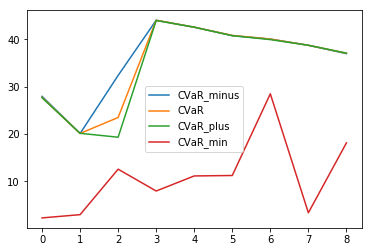

In [35]:
plot_data.plot()

In [ ]:
#to get x_{i,1}'s for all i \in k 
def get_start_point(t, weight):
    B_divide_c_i=[Cost_Bound/get_cost_for_k(t)[i] for i in range(0,len(k))  ]
    #s=sum(x)
    #l = [x * 2 for x in l]
    x=[weight*B_divide_c_i]
    return list(x)
    #x=np.array([Cost_Bound / get_cost_for_k(t)] )
#get_start_point(1,w1_new)


In [ ]:
#test to convert it into array to simple type to be accepted in LP programe 
#o=get_start_point(1,w1)
#o.append(0)
#o

In [ ]:
#Karmarskar algorithm to solve system of linear equation and get x_{i,1} for 1st 2 equations in optimization problem 

import numpy as np


class LPSolution(object):
    def __init__(self):
        self.iterations = None
        self.tolerance = None
        self.intermediates = []
        self.solution = []
        self.solution_string = None

    def __str__(self):
        self.solution_string =str(self.solution)
        #self.solution_string += '\n\tTolerance: ' + str(self.tolerance)
        #self.solution_string += '\n\tIterations: ' + str(self.iterations)
        return self.solution_string


class LinearProgram(object):
    """A class that implements Karmarkar's Algorithm for the solution of
    Linear Programs in standard form."""
    def __init__(self, A, b, c):
        """Constructs an n-variable m-constraint Linear Program.

        A -- An n x m numpy matrix of constraint coefficients
        b -- A 1 x m numpy row vector of constraint RHS values
        c -- A 1 x n numpy row vector of objective function coefficients
        """
        self.A = A
        self.n, self.m = self.A.shape
        self.b = b
        self.c = c
        self.solution = []

    def karmarkar(self, start_point):
        """Runs one iteration of Karmarkar's Algorithm.

        start_point -- A 1 x n numpy row vector of decision variable values
        """
        D = np.diagflat(start_point)
        c_tilde = np.matmul(self.c, D)
        A_tilde = np.matmul(self.A, D)
        A_tildeT = A_tilde.transpose()
        AAT_inverse = np.linalg.inv(np.matmul(A_tilde, A_tildeT))
        # matrix multiplication is associative
        P = np.identity(self.m) - np.matmul(np.matmul(A_tildeT, AAT_inverse), A_tilde)
        cp_tilde = np.matmul(c_tilde, P)
        k = -0.5 / np.amin(cp_tilde)
        x_tilde_new = np.ones((1, self.m), order='F') + k * cp_tilde
        return np.matmul(x_tilde_new, D)

    def solve(self, start_point, tolerance=1e-5, max_iterations=50, verbose=False):
        """Uses Karmarkar's Algorithm to solve a Linear Program.

        start_point     -- A starting point for Karmarkar's Algorithm. Must be a row vector.
        tolerance       -- The stopping tolerance of Karmarkar's Algorithm.
        max_iterations  -- The maximum number of iterations to run Karmarkar's Algorithm.
        verbose         -- List all intermediate values.
        """
        x = start_point
        solution = LPSolution()
        for i in range(max_iterations):
            x_new = self.karmarkar(x)
            if verbose:
                print(x_new)

            dist = np.linalg.norm(x - x_new)
            x = x_new
            solution.intermediates.append(x)
            if dist < tolerance:
                break

        solution.solution = x
        solution.iterations = i
        solution.tolerance = dist
        self.solution = solution

        return solution

In [ ]:

#k=get_cost(1)
#k.append(1)
#!/usr/bin/python3
import numpy as np
#from linear_program import LinearProgram, LPSolution


def generate_tikz_plot(solution):
    """Generates a 3D Tikz LaTeX coordinate strings for the intermediate solutions."""
    for i, soln in enumerate(solution.intermediates):
        coordinate = r'\coordinate (xnew{}) at '.format(i)
        coordinate += r'({}, {}, {});'.format(*[coord for coord in soln.flat])
        print(coordinate)

    draw = r'\draw[red] (x) node[circle, fill, inner sep=1pt] '
    for i in range(len(solution.intermediates)):
        draw += r'-- (xnew{}) node[circle, fill, inner sep=1pt] '.format(i)
    draw += r';'
    print(draw)


def main(t,start_point):
    n=get_cost_for_k(t)
    n.append(1)
    
    m=estimated_reward(t)
    m.append(0)
    
    start_point=start_point.append(0)

    
    #k.append(1)
    #A = np.matrix([get_cost(t), ])
    A = np.matrix([n, ])
    b = np.array([Cost_Bound, ])
    #c = np.array([1, 2, 0])
    c = np.array(m)

    LP = LinearProgram(A, b, c)
    LP.solve(start_point=np.array(start_point))
    return (LP.solution)


if __name__ == '__main__':
    main(1,get_start_point(1,w1))
    



In [ ]:
def Convert(string): 
    li = list(string.split( )) 
    return li 

def get_solution_karmarskar_algo(t,start_point):
    
    y=Convert(str(main(t,start_point)))
    x_k_1 = list(filter(None,y )) # fastest
    #print(y)
    #print(x_k_1)

    #removing "\n" part from the list
    x_k_1=list(map(str.strip,x_k_1))
    #print(x_k_1)

    #removing last element from the list
    x_k_1=x_k_1[:-1]
    #x_k_1

    #removing unneccesory elements from 1st element of x_k_1
    #print(x_k_1[0])
    type(x_k_1)
    #sum(float(i) for i in x_k_1)

    #print(x_k_1[0])
    x_k_1[0]=x_k_1[0][2:]
    
    #converting every element of x_k_1 which was initially string type to float type
    x_k_1=[float(x) for x in x_k_1]
    
    return x_k_1
#get_solution_karmarskar_algo(1)

In [ ]:
#y=main()
#print(y)
#str(y)

y=Convert(str(main(1,get_start_point(1,w1))))
x_k_1 = list(filter(None,y )) # fastest
#print(y)
#print(x_k_1)

#removing "\n" part from the list
x_k_1=list(map(str.strip,x_k_1))
#print(x_k_1)

#removing last element from the list
x_k_1=x_k_1[:-1]
#x_k_1

#removing unneccesory elements from 1st element of x_k_1
#print(x_k_1[0])
type(x_k_1)
#sum(float(i) for i in x_k_1)

#print(x_k_1[0])
x_k_1[0]=x_k_1[0][2:]
x_k_1

In [ ]:
#converting every element of x_k_1 which was initially string type to float type
x_k_1=[float(x) for x in x_k_1]
x_k_1


In [ ]:
def get_weight_from_securities(x):
    weight=[x[i]/sum(x) for i in range(0,len(k))]
    return weight
weight_from_securities=get_weight_from_securities(x_k_1)
weight_from_securities=np.array(w)
weight_from_securities

In [ ]:
cvar = negative_cvar( weight_from_securities, dataset_reward,1,s=5000, random_state=0)
assert cvar > 0
cvar


In [ ]:
def secant(f,a,b,N):
    '''Approximate solution of f(x)=0 on interval [a,b] by the secant method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    m_N : number
        The x intercept of the secant line on the the Nth interval
            m_n = a_n - f(a_n)*(b_n - a_n)/(f(b_n) - f(a_n))
        The initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0
        for some intercept m_n then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iterations, the secant method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> secant(f,1,2,5)
    1.6180257510729614
    '''
    if f(a)*f(b) >= 0:
        print("Secant method fails.")
        return None
    a_n = a
    b_n = b
    for n in range(1,N+1):
        m_n = a_n - f(a_n)*(b_n - a_n)/(f(b_n) - f(a_n))
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Secant method fails.")
            return None
    return a_n - f(a_n)*(b_n - a_n)/(f(b_n) - f(a_n))



In [ ]:
def f(o):
    return (negative_cvar(o, dataset_reward,1,s=5000, random_state=0)-theta*cvar_min)

#f=(negative_cvar( w, returns,1,s=5000, random_state=0)-theta*cvar_min)
random_guess_for_weight=np.array([1 / df.shape[0]] * df.shape[0])
secant(f, weight_from_securities,random_guess_for_weight,5)


In [ ]:
while(cvar>theta*cvar_min):
    nearby_point=secant(f, weight_from_securities,w1_new,5) 
    get_solution_karmarskar_algo(1,nearby_point)

In [ ]:
nearby_point=secant(f, weight_from_securities,w1_new,5) 
get_solution_karmarskar_algo(1,nearby_point)